# Amazon SageMaker XGBoostを使ったターゲティングダイレクトマーケティング
## Background
郵便、電子メール、電話などによるダイレクトマーケティングは、顧客を獲得するための一般的な戦術です。 リソースと顧客の注意力は限られているため、目標は特定のオファーに関与する可能性が高い見込み客のサブセットのみをターゲットにすることです。 人口統計、過去の交流、環境要因などの入手しやすい情報に基づいて、これらの潜在顧客を予測することは、一般的な機械学習問題です。

このノートでは、1回以上の電話連絡の後、顧客が銀行で定期預金に加入するかどうかを予測する問題の例を紹介します。 手順は以下の通りです：

* Amazon SageMakerノートブックの準備
* インターネットからAmazon SageMakerにデータをダウンロードする。
* Amazon SageMakerのアルゴリズムに供給できるように、データを調査し、変換する。
* グラディエントブースティングアルゴリズムを用いたモデルの推定
* モデルの有効性の評価
* 継続的な予測を行うためのモデルのセットアップ

---

## Preparation
このノートブックは、ml.m4.xlargeノートブックインスタンスで作成され、テストされています。

まずは指定するところから始めましょう：

- トレーニングおよびモデルデータに使用するS3バケットとプレフィックス。 これは、Notebookインスタンス、トレーニング、ホスティングと同じリージョン内にある必要があります。
- trainingとhostingにデータへのアクセス権を与えるために使用するIAMロールArn。これらの作成方法についてはドキュメントを参照してください。 ノートブックインスタンス、トレーニング、ホスティングに複数のロールが必要な場合は、boto regexpを適切なIAMロールarnの文字列に置き換えてください。

In [ ]:
# cell 01
import sagemaker
bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-dm'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

では、解析で使用するPythonのライブラリを導入してみましょう。

In [ ]:
# cell 02
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 
import zipfile     # Amazon SageMaker's Python SDK provides many helper functions

---

## Data
まずはサンプルデータs3バケットから[ダイレクトマーケティングデータセット](https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip)をダウンロードしましょう。

\Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. 意思決定支援システム、エルゼビア、62:22-31、2014年6月


### Transformation
変換ステップは、DataWrangler & Features Storeで行いました。
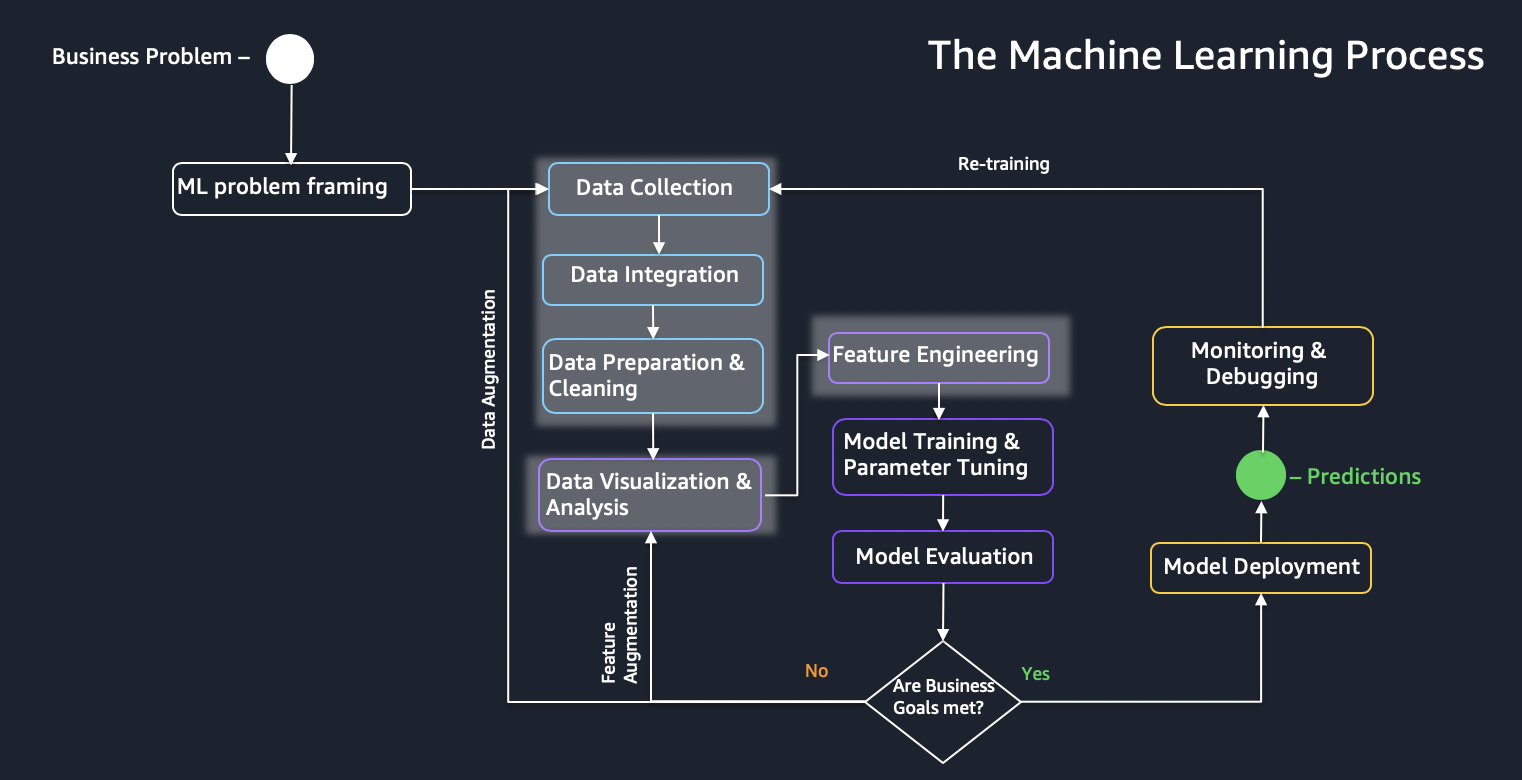

**Get the data from FS**

In [ ]:
# cell 03
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup

region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

feature_group_name = "YOUR FEATURE GROUP NAME"
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)

In [ ]:
# cell 04
# Build SQL query to features group
fs_query = feature_group.athena_query()
fs_table = fs_query.table_name
query_string = 'SELECT * FROM "'+fs_table+'"'
print('Running ' + query_string)

In [ ]:
# cell 05
# Run Athena query. The output is loaded to a Pandas dataframe.
fs_query.run(query_string=query_string, output_location='s3://'+bucket+'/'+prefix+'/fs_query_results/')
fs_query.wait()
model_data = fs_query.as_dataframe()

In [ ]:
# cell 06
model_data = model_data.drop(['fs_id', 'fs_time', 'write_time', 'api_invocation_time', 'is_deleted'], axis=1)

In [ ]:
# cell 07
model_data

新しいデータに対して目標値を予測することを主目的とするモデルを構築する場合、オーバーフィッティングを理解することが重要である。 教師あり学習モデルは、与えられたデータの中で、目標値の予測値と実際の値の誤差を最小にするように設計されています。 この最後の部分が重要で、機械学習モデルは、より高い精度を求めるあまり、与えられたデータの中の些細な特異性を拾い上げるように偏ることがよくあります。 このような特異性は、その後のデータでは再現されないため、学習段階でより精度の高い予測を行う代わりに、予測の精度を下げてしまう可能性があります。

これを防ぐ最も一般的な方法は、モデルは学習させたデータへの適合性だけでなく、「新しい」データへの適合性も含めて判断されるべきであるという考え方でモデルを構築することです。 ホールドアウト検証、クロスバリデーション、リーブオンアウト検証など、この運用方法はいくつかあります。 今回の目的では、単純にデータを3つの不均等なグループにランダムに分割することにします。 70%のデータでモデルを学習させ、20%のデータで評価し、「新しい」データでの精度を推定し、10%は後で使用する最終テストデータセットとして保持します。

In [ ]:
# cell 08
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

Amazon SageMakerのXGBoostコンテナは、libSVMまたはCSVデータ形式のデータを期待しています。 この例では、CSVにこだわることにします。 最初のカラムはターゲット変数でなければならず、CSVにはヘッダーを含めてはならないことに注意してください。 また、繰り返しになりますが、train|validation|testの分割の前ではなく、後に行うのが最も簡単であることに注意してください。 これにより、ランダムな並び替えによるズレの問題を回避することができます。

In [ ]:
# cell 09
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

あとは、Amazon SageMakerのマネージドトレーニングでピックアップするために、S3にファイルをコピーしておきます。

In [ ]:
# cell 10
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---

## End of Lab 1


---

## Training
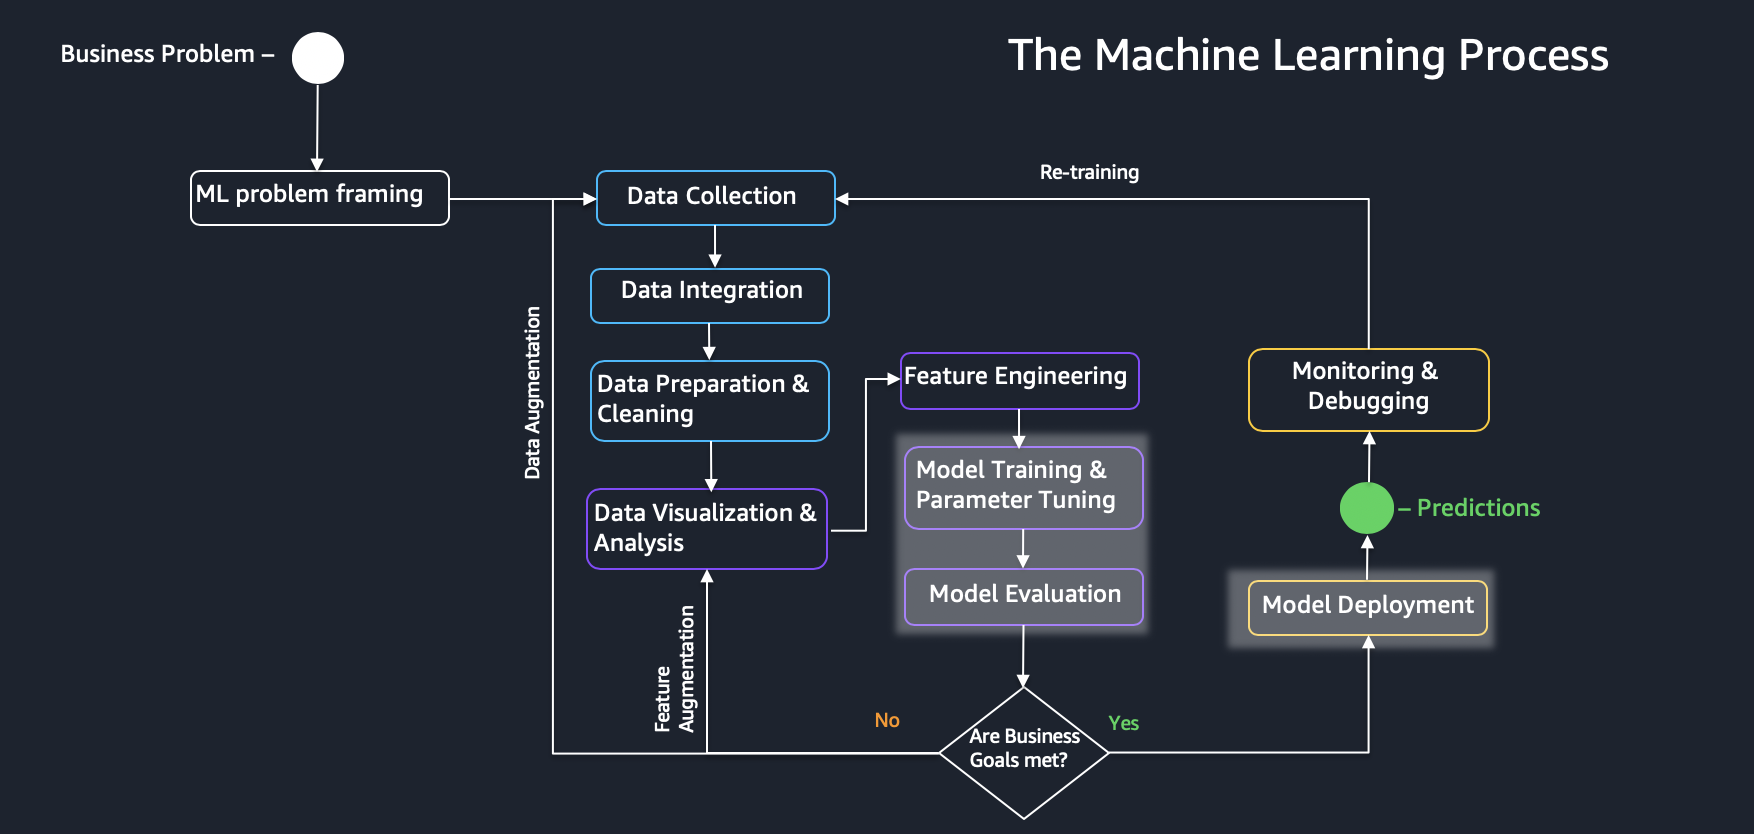
ここで、特徴量の多くは分布が歪んでいること、互いに相関が高いこと、対象変数と非線形の関係があるように見えることなどが分かっています。 また、将来の見込み客をターゲットにする場合、予測精度が高い方が、なぜその見込み客をターゲットにしたのかを説明できるよりも好ましい。 これらの点を総合すると、勾配ブースト木は良い候補のアルゴリズムであると言えます。

このアルゴリズムを理解するにはいくつかの複雑な要素がありますが、簡単に言うと、勾配木は多くの単純なモデルからの予測を組み合わせることで機能します。 このようにすることで、単純なモデルの集まりは、大規模で複雑なモデルよりも実際に優れていることがあります。 他の Amazon SageMaker ノートブックでは、勾配ブースティング木についてさらに詳しく説明し、同様のアルゴリズムとどのように異なるかを説明しています。

xgboost`は、勾配ブースティング木のための非常に人気のあるオープンソースのパッケージです。 計算能力が高く、機能も充実しており、多くの機械学習コンテストで成功裏に使用されています。 まず、Amazon SageMakerの管理された分散トレーニングフレームワークを使用してトレーニングされた、シンプルな`xgboost`モデルから始めてみましょう。

まず、Amazon SageMakerのXGBoostの実装のためのECRコンテナの場所を指定する必要があります。

In [ ]:
# cell 11
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

そして、今回はCSVファイル形式でトレーニングを行うので、トレーニング関数がS3内のファイルへのポインタとして使用できるように、`s3_input`を作成します。

In [ ]:
# cell 12
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

まず、推定量に対する学習パラメータを指定する必要があります。 これには以下のようなものがあります：
1. xgboost`アルゴリズムのコンテナ
2. 使用するIAMロール
3. トレーニングインスタンスの種類と数
4. 出力データのS3ロケーション
5. アルゴリズムのハイパーパラメータ

そして、`.fit()`関数で指定する：
6. 出力データのS3ロケーション。 この場合、トレーニングセットとバリデーションセットの両方が渡されます。

In [ ]:
# cell 13
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

---

## Hosting
さて、データに対して `xgboost` アルゴリズムをトレーニングしたので、リアルタイムエンドポイントの背後にホストされたモデルをデプロイしてみましょう。

In [ ]:
# cell 14
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

---

## Evaluation
機械学習モデルの性能を比較する方法はいろいろありますが、まずは単純に実績値と予測値を比較することから始めましょう。 この場合、顧客が定期預金を申し込んだかどうか（`1`）、あるいは申し込まなかったかどうか（`0`）を予測するだけなので、単純な混同行列が生成されます。

まず、エンドポイントにデータを渡す方法とエンドポイントからデータを受け取る方法を決定する必要があります。 現在、データはNumPyの配列としてnotebookインスタンスのメモリに格納されています。 これをHTTP POSTリクエストで送信するには、CSV文字列としてシリアライズし、そのCSVをデコードすることになります。

*注：CSV形式の推論を行う場合、SageMaker XGBoostでは、データにターゲット変数が含まれていないことが必要です。

In [ ]:
# cell 15
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

では、簡単な関数を使って
1. テストデータセットをループさせる
2. 行のミニバッチに分割する 
3. これらのミニバッチをCSV文字列に変換する（最初にデータセットからターゲット変数を削除していることに注意）。
4. XGBoostのエンドポイントを呼び出して、ミニバッチの予測値を取得する。
5. 予測値を収集し、モデルが提供するCSV出力からNumPyの配列に変換する。

In [ ]:
# cell 16
def predict(data, predictor, rows=500 ):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy(), xgb_predictor)

ここで、混乱マトリックスを確認し、予測と実際がどの程度一致したかを確認します。

In [ ]:
# cell 17
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

つまり、6938人の潜在顧客のうち、3095人が加入すると予測し、そのうちの2986人が実際に加入しました。 また、予測しなかった購読者が414人いました。この結果を改善するために、モデルをチューニングすることができます（そして、そうすべきです）。 最も重要なことは、最小限の努力で、我々のモデルは、[こちら](http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf)で発表されたものと同様の精度を達成したことである。

アルゴリズムのサブサンプルにはランダム性があるため、結果は上に書いた文章と若干異なる可能性があることに注意してください。

### Clean Up
このノートブックで作成したリソースのうち、不要になったものを削除します。

In [ ]:
# cell 28
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

--
## Serverless Deployment (Optional)
モデルをトレーニングした後、モデルをエンドポイントにデプロイできるように、モデルのアーティファクトを取得する。

In [ ]:
# Setup clients
import boto3

client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")

In [ ]:
# Retrieve model data from training job
model_artifacts = xgb.model_data
model_artifacts

### Model Creation
モデルの成果物、コンテナイメージの URI、コンテナの環境変数（該当する場合）、モデル名、および SageMaker IAM ロールを指定して、モデルを作成します。

In [ ]:
from time import gmtime, strftime

model_name = "xgboost-serverless" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: " + model_name)

# dummy environment variables
byo_container_env_vars = {"SAGEMAKER_CONTAINER_LOG_LEVEL": "20", "SOME_ENV_VAR": "myEnvVar"}

create_model_response = client.create_model(
    ModelName=model_name,
    Containers=[
        {
            "Image": container,
            "Mode": "SingleModel",
            "ModelDataUrl": model_artifacts,
            "Environment": byo_container_env_vars,
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

### Endpoint Configuration Creation
ここで、エンドポイントのServerless Configurationを調整することができます。MaxConcurrencyとして知られている単一のエンドポイントの現在の最大同時呼び出しは、1から200までの任意の値にすることができ、MemorySizeは、次のいずれかにすることができます： 1024MB、2048MB、3072MB、4096MB、5120MB、または6144MBです。

In [ ]:
xgboost_epc_name = "xgboost-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=xgboost_epc_name,
    ProductionVariants=[
        {
            "VariantName": "byoVariant",
            "ModelName": model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

### Serverless Endpoint Creation
エンドポイント設定ができたので、サーバーレスエンドポイントを作成し、そこにモデルをデプロイすることができます。エンドポイントを作成する際に、エンドポイント設定の名前と新しいエンドポイントの名前を指定します。

In [ ]:
endpoint_name = "xgboost-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=xgboost_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

エンドポイントのステータスがInServiceになるまで待ってから、エンドポイントを呼び出す。

In [ ]:
# wait for endpoint to reach a terminal state (InService) using describe endpoint
import time

describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

### Endpoint Invocation
エンドポイントにリクエストを送信して、エンドポイントを呼び出します。以下は、Direct Marketing データセットから取得したデータポイントのサンプルです。

In [ ]:
payload = b"3., 999.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0., 0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1., 0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1., 0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0., 0.,   1.,   0."

response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType="text/csv",
)

print(response["Body"].read().decode())

### Clean Up
このノートで作成したリソースのうち、不要になったものは削除してください。

In [ ]:
client.delete_model(ModelName=model_name)
client.delete_endpoint_config(EndpointConfigName=xgboost_epc_name)
client.delete_endpoint(EndpointName=endpoint_name)

## Automatic model Tuning (optional)
Amazon SageMakerの自動モデルチューニングは、ハイパーパラメータチューニングとしても知られており、指定したアルゴリズムとハイパーパラメータの範囲を使用してデータセット上で多くのトレーニングジョブを実行することにより、モデルのベストバージョンを見つけます。そして、選択した指標で測定した結果、最も優れたパフォーマンスを発揮するモデルを実現するハイパーパラメータ値を選択します。
例えば、このマーケティングデータセットで二値分類問題を解くとします。あなたの目標は、XGBoostアルゴリズムのモデルをトレーニングすることによって、アルゴリズムの曲線下面積（auc）メトリックを最大化することです。最適なモデルをトレーニングするために、eta、alpha、min_child_weight、max_depthのハイパーパラメータのどの値を使用すればよいかはわかりません。これらのハイパーパラメータの最適な値を見つけるために、Amazon SageMakerのハイパーパラメータチューニングが検索する値の範囲を指定し、選択した目的メトリックで測定される最高のパフォーマンスを持つトレーニングジョブになる値の組み合わせを見つけることができます。ハイパーパラメータチューニングは、指定した範囲のハイパーパラメータ値を使用するトレーニングジョブを起動し、最も高いaucを持つトレーニングジョブを返します。


In [ ]:
# cell 18
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}


In [ ]:
# cell 19
objective_metric_name = 'validation:auc'

In [ ]:
# cell 20
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)


In [ ]:
# cell 21
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [ ]:
# cell 22
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

In [ ]:
# cell 23
# return the best training job name
tuner.best_training_job()

In [ ]:
# cell 24
#  Deploy the best trained or user specified model to an Amazon SageMaker endpoint
tuner_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

In [ ]:
# cell 25
# Create a serializer
tuner_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [ ]:
# cell 26
# Predict
predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy(),tuner_predictor)

In [ ]:
# cell 27
# Collect predictions and convert from the CSV output our model provides into a NumPy array
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

---

## Extensions
この例では、比較的小さなデータセットを分析しましたが、分散管理されたトレーニングやリアルタイムモデルホスティングといったAmazon SageMakerの機能を利用しており、より大きな問題にも簡単に適用することができます。 予測精度をさらに向上させるために、予測の閾値を微調整して、偽陽性と偽陰性の組み合わせを変えたり、ハイパーパラメータチューニングのようなテクニックを検討したりすることもできます。 また、実世界のシナリオでは、手作業による特徴量のエンジニアリングに時間をかけ、最初のデータセットでは得られなかった顧客情報を含む追加データセットを探すことになるでしょう。

### Clean-up
このノートブックが完成したら、以下のセルを実行してください。 これで、作成したホスト型エンドポイントが削除され、野良インスタンスがオンになっていたことによる課金が回避されます。

In [ ]:
# cell 29
tuner_predictor.delete_endpoint(delete_endpoint_config=True)